## Data Extraction from Different Platform Data Sources



In [35]:
import pandas as pd
import numpy as np
import os
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine

# optional 
import warnings
warnings.filterwarnings("ignore")


In [36]:
import pandas as pd

# Base folder path
base_path = r"C:\Users\nisha\OneDrive\Desktop\SPICE_ACADEMY\Marketing_data\data"

# File mapping
files = {
    "meta_mx": "social_meta_mx.csv",
    "meta_non_mx": "social_meta_non_mx.csv",
    "pinterest": "social_pinterest.csv",
    "reddit": "social_reddit.csv"
}

# Load all files into a dictionary of DataFrames
dfs = {}

for name, filename in files.items():
    path = f"{base_path}\\{filename}"
    dfs[name] = pd.read_excel(path)
    print(f"{name}: {dfs[name].shape}")



meta_mx: (81681, 30)
meta_non_mx: (88884, 30)
pinterest: (715, 30)
reddit: (89, 30)


In [37]:
dfs["meta_mx"].head()
dfs["meta_mx"].columns
dfs["meta_mx"].info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81681 entries, 0 to 81680
Data columns (total 30 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   Media_Channel__CH             81681 non-null  object        
 1   Type                          81681 non-null  object        
 2   Platform__PL                  79402 non-null  object        
 3   Data_Source                   81681 non-null  object        
 4   Funding_Source__FS            81681 non-null  object        
 5   Sub_Brand__SB                 81681 non-null  object        
 6   Product_Category__PR          81681 non-null  object        
 7   Campaign_Name                 81681 non-null  object        
 8   Line_Item                     0 non-null      float64       
 9   Campaign_Name__CN             81681 non-null  object        
 10  Placement_Description__PD     0 non-null      float64       
 11  Mindset__MD                 

## Cleaning all the dataframes in single loop dropping null values and null coloumns

In [38]:
import re

def extract_campaign_id(text):
    if isinstance(text, str):
        match = re.search(r'ID~([^_]+)', text)
        return match.group(1) if match else None
    return None


In [39]:
dfs_cleaned = {}

for name, df in dfs.items():
    print(f"\nCleaning {name}...")

    # Drop empty columns
    #df = df.dropna(axis=1, how='all')

    # Drop empty rows
    #df = df.dropna(how='all')

    # Clean column names
    df.columns = (
        df.columns
        .str.strip()
        .str.lower()
        .str.replace(" ", "_")
        .str.replace("__", "_")
        .str.replace("(", "")
        .str.replace(")", "")
    )

    # Extract campaign_id if campaign_name exists
    if "campaign_name" in df.columns:
        df["campaign_id"] = df["campaign_name"].apply(extract_campaign_id)

    # -----------------------------------------
    #Convert numeric-looking columns FIRST
    # -----------------------------------------
    for col in df.columns:
        if col != "date":   # <-- Prevent overwriting date
            df[col] = pd.to_numeric(df[col], errors="ignore")

    # -----------------------------------------
    #Convert nanosecond timestamps to datetime
    # -----------------------------------------
    if "date" in df.columns:
        df["date"] = pd.to_datetime(df["date"], unit="ns", errors="coerce")

    # Drop duplicates
    df = df.drop_duplicates()

    # Add platform identifier
    df["platform"] = name

    dfs_cleaned[name] = df

    print(f"{name} cleaned. Shape: {df.shape}")



Cleaning meta_mx...
meta_mx cleaned. Shape: (81681, 32)

Cleaning meta_non_mx...
meta_non_mx cleaned. Shape: (88884, 32)

Cleaning pinterest...
pinterest cleaned. Shape: (715, 32)

Cleaning reddit...
reddit cleaned. Shape: (89, 32)


In [40]:
for name, df in dfs_cleaned.items():
    print(f"\n{name} columns:")
    print(df.columns.tolist())



meta_mx columns:
['media_channel_ch', 'type', 'platform_pl', 'data_source', 'funding_source_fs', 'sub_brand_sb', 'product_category_pr', 'campaign_name', 'line_item', 'campaign_name_cn', 'placement_description_pd', 'mindset_md', 'date', 'quarter', 'month', 'cw_iso', 'year', 'division_bs', 'business_activity', 'kpi_pk', 'adserving_method_ad', 'costs', 'cost_usd', 'impressions', 'clicks', 'total_conversions', 'total_conversions_revenue', 'total_conversion_revenue_usd', 'mobile_app_installs', 'objective_ob', 'campaign_id', 'platform']

meta_non_mx columns:
['media_channel_ch', 'type', 'platform_pl', 'data_source', 'funding_source_fs', 'sub_brand_sb', 'product_category_pr', 'campaign_name', 'line_item', 'campaign_name_cn', 'placement_description_pd', 'mindset_md', 'date', 'quarter', 'month', 'cw_iso', 'year', 'division_bs', 'business_activity', 'kpi_pk', 'adserving_method_ad', 'costs', 'cost_usd', 'impressions', 'clicks', 'total_conversions', 'total_conversions_revenue', 'total_conversion_

## cleaning done coloumn names has been uniformed case lowered and platform added as a extra column now creating engine to push it to datawarehouse and extracted campaign ID from each data source

In [41]:
POSTGRES_USER = "nishantsingh"
POSTGRES_PASS = "MViOfwCs2ZrSVoV3"
POSTGRES_HOST = "data-analytics-course-2.c8g8r1deus2v.eu-central-1.rds.amazonaws.com"
POSTGRES_PORT = "5432"
POSTGRES_DB = "jalapeno_joins"
POSTGRES_SCHEMA = "s_nishantsingh"


In [42]:
engine = create_engine(
    f"postgresql://{POSTGRES_USER}:{POSTGRES_PASS}@{POSTGRES_HOST}:{POSTGRES_PORT}/{POSTGRES_DB}"
)


In [43]:
from sqlalchemy import text

tables_to_drop = [
    "meta_mx",
    "meta_non_mx",
    "pinterest",
    "reddit"
]

with engine.connect() as conn:
    for table in tables_to_drop:
        sql = f'DROP TABLE IF EXISTS {POSTGRES_SCHEMA}.{table} CASCADE'
        print("Dropping:", sql)
        conn.execute(text(sql))
    conn.commit()


Dropping: DROP TABLE IF EXISTS s_nishantsingh.meta_mx CASCADE
Dropping: DROP TABLE IF EXISTS s_nishantsingh.meta_non_mx CASCADE
Dropping: DROP TABLE IF EXISTS s_nishantsingh.pinterest CASCADE
Dropping: DROP TABLE IF EXISTS s_nishantsingh.reddit CASCADE


In [44]:
for name, df in dfs_cleaned.items():
    print(f"Loading {name} with shape {df.shape}")
    df.to_sql(
        name,
        engine,
        schema=POSTGRES_SCHEMA,
        if_exists="replace",
        index=False
    )
    print(f"Loaded {name}")



Loading meta_mx with shape (81681, 32)
Loaded meta_mx
Loading meta_non_mx with shape (88884, 32)
Loaded meta_non_mx
Loading pinterest with shape (715, 32)
Loaded pinterest
Loading reddit with shape (89, 32)
Loaded reddit


#Preparing CAC Model--- concating all the dataframes in one

In [45]:
#concate all the cleaned dataframes in one
df_all = pd.concat(dfs_cleaned.values(), ignore_index=True)



In [46]:
df_all.head()
df_all.columns


Index(['media_channel_ch', 'type', 'platform_pl', 'data_source',
       'funding_source_fs', 'sub_brand_sb', 'product_category_pr',
       'campaign_name', 'line_item', 'campaign_name_cn',
       'placement_description_pd', 'mindset_md', 'date', 'quarter', 'month',
       'cw_iso', 'year', 'division_bs', 'business_activity', 'kpi_pk',
       'adserving_method_ad', 'costs', 'cost_usd', 'impressions', 'clicks',
       'total_conversions', 'total_conversions_revenue',
       'total_conversion_revenue_usd', 'mobile_app_installs', 'objective_ob',
       'campaign_id', 'platform'],
      dtype='object')

In [47]:
import pandas as pd

# Combine all cleaned platform DataFrames into one
df_all = pd.concat(dfs_cleaned.values(), ignore_index=True)

print("Combined shape:", df_all.shape)
print("Columns:", df_all.columns.tolist())


Combined shape: (171369, 32)
Columns: ['media_channel_ch', 'type', 'platform_pl', 'data_source', 'funding_source_fs', 'sub_brand_sb', 'product_category_pr', 'campaign_name', 'line_item', 'campaign_name_cn', 'placement_description_pd', 'mindset_md', 'date', 'quarter', 'month', 'cw_iso', 'year', 'division_bs', 'business_activity', 'kpi_pk', 'adserving_method_ad', 'costs', 'cost_usd', 'impressions', 'clicks', 'total_conversions', 'total_conversions_revenue', 'total_conversion_revenue_usd', 'mobile_app_installs', 'objective_ob', 'campaign_id', 'platform']


In [48]:
df_all = pd.concat(dfs_cleaned.values(), ignore_index=True)

print("Combined shape:", df_all.shape)
print("Columns:", df_all.columns.tolist())



Combined shape: (171369, 32)
Columns: ['media_channel_ch', 'type', 'platform_pl', 'data_source', 'funding_source_fs', 'sub_brand_sb', 'product_category_pr', 'campaign_name', 'line_item', 'campaign_name_cn', 'placement_description_pd', 'mindset_md', 'date', 'quarter', 'month', 'cw_iso', 'year', 'division_bs', 'business_activity', 'kpi_pk', 'adserving_method_ad', 'costs', 'cost_usd', 'impressions', 'clicks', 'total_conversions', 'total_conversions_revenue', 'total_conversion_revenue_usd', 'mobile_app_installs', 'objective_ob', 'campaign_id', 'platform']


In [49]:
def safe_cac(costs, conversions):
    if conversions and conversions > 0:
        return costs / conversions
    return None


In [50]:

engine.dispose()
engine = create_engine(
    f"postgresql://{POSTGRES_USER}:{POSTGRES_PASS}@{POSTGRES_HOST}:{POSTGRES_PORT}/{POSTGRES_DB}"
)




In [51]:
df_all["objective_ob"] = (
    df_all["objective_ob"]
    .astype(str)
    .str.strip()
    .str.lower()
)


In [52]:
# Clean objective column
df_all["objective_ob"] = (
    df_all["objective_ob"]
    .astype(str)
    .str.strip()
    .str.lower()
)

# Filter only conversion campaigns
df_cac = df_all[df_all["objective_ob"].str.contains("conversion", na=False)]


In [53]:
df_cac.shape
df_cac["objective_ob"].unique()


array(['03 conversion (sales/lead gen/remarketing)'], dtype=object)

In [54]:
df_cac = df_all[df_all["objective_ob"].str.contains("conversion", na=False)]
print("Rows after conversion filter:", df_cac.shape[0])
print(df_cac["objective_ob"].unique())


Rows after conversion filter: 171369
['03 conversion (sales/lead gen/remarketing)']


In [55]:
def safe_cac(costs, conversions):
    if conversions and conversions > 0:
        return costs / conversions
    return None


In [56]:
cac_bu = (
    df_cac.groupby(["date", "division_bs"], as_index=False)
    .agg({
        "costs": "sum",
        "total_conversions": "sum"
    })
)

cac_bu["CAC"] = cac_bu.apply(
    lambda row: safe_cac(row["costs"], row["total_conversions"]),
    axis=1
)


In [57]:
with engine.begin() as conn:
    cac_bu.to_sql(
        "cac_by_bu",
        conn,
        schema=POSTGRES_SCHEMA,
        if_exists="replace",
        index=False
    )


In [58]:
# ---------------------------------------------
# 1. Combine all cleaned DataFrames
# ---------------------------------------------
df_all = pd.concat(dfs_cleaned.values(), ignore_index=True)

print("Combined shape:", df_all.shape)
print("Columns:", df_all.columns.tolist())


# ---------------------------------------------
# 2. Clean objective column
# ---------------------------------------------
df_all["objective_ob"] = (
    df_all["objective_ob"]
    .astype(str)
    .str.strip()
    .str.lower()
)


# ---------------------------------------------
# 3. Filter only conversion campaigns
# ---------------------------------------------
df_cac = df_all[df_all["objective_ob"].str.contains("conversion", na=False)]

print("Rows after conversion filter:", df_cac.shape[0])
print("Unique objectives:", df_cac["objective_ob"].unique())


# ---------------------------------------------
# 4. Safe CAC calculation helper
# ---------------------------------------------
def safe_cac(costs, conversions):
    if conversions and conversions > 0:
        return costs / conversions
    return None


# ---------------------------------------------
# 5. CAC by Business Unit (division_bs)
# ---------------------------------------------
cac_bu = (
    df_cac.groupby(["date", "division_bs"], as_index=False)
    .agg({
        "costs": "sum",
        "total_conversions": "sum"
    })
)

cac_bu["CAC"] = cac_bu.apply(
    lambda row: safe_cac(row["costs"], row["total_conversions"]),
    axis=1
)


# ---------------------------------------------
# 6. CAC by Business Unit + Platform
# ---------------------------------------------
cac_bu_platform = (
    df_cac.groupby(["date", "division_bs", "platform"], as_index=False)
    .agg({
        "costs": "sum",
        "total_conversions": "sum"
    })
)

cac_bu_platform["CAC"] = cac_bu_platform.apply(
    lambda row: safe_cac(row["costs"], row["total_conversions"]),
    axis=1
)


# ---------------------------------------------
# 7. CAC by Business Unit + Platform + Campaign
# ---------------------------------------------
cac_bu_platform_campaign = (
    df_cac.groupby(["date", "division_bs", "platform", "campaign_id"], as_index=False)
    .agg({
        "costs": "sum",
        "total_conversions": "sum"
    })
)

cac_bu_platform_campaign["CAC"] = cac_bu_platform_campaign.apply(
    lambda row: safe_cac(row["costs"], row["total_conversions"]),
    axis=1
)


# ---------------------------------------------
# 8. Push CAC tables to Postgres
# ---------------------------------------------
with engine.begin() as conn:
    pass


Combined shape: (171369, 32)
Columns: ['media_channel_ch', 'type', 'platform_pl', 'data_source', 'funding_source_fs', 'sub_brand_sb', 'product_category_pr', 'campaign_name', 'line_item', 'campaign_name_cn', 'placement_description_pd', 'mindset_md', 'date', 'quarter', 'month', 'cw_iso', 'year', 'division_bs', 'business_activity', 'kpi_pk', 'adserving_method_ad', 'costs', 'cost_usd', 'impressions', 'clicks', 'total_conversions', 'total_conversions_revenue', 'total_conversion_revenue_usd', 'mobile_app_installs', 'objective_ob', 'campaign_id', 'platform']
Rows after conversion filter: 171369
Unique objectives: ['03 conversion (sales/lead gen/remarketing)']


In [59]:
engine.dispose()
del engine

engine = create_engine(
    f"postgresql://{POSTGRES_USER}:{POSTGRES_PASS}@{POSTGRES_HOST}:{POSTGRES_PORT}/{POSTGRES_DB}",
    pool_pre_ping=True,
    pool_recycle=1800
)


In [60]:
#pushing cac into datawarehouse
with engine.begin() as conn:
    cac_bu.to_sql(
        "cac_by_bu",
        conn,
        schema=POSTGRES_SCHEMA,
        if_exists="replace",
        index=False
    )

    cac_bu_platform.to_sql(
        "cac_by_bu_platform",
        conn,
        schema=POSTGRES_SCHEMA,
        if_exists="replace",
        index=False
    )

    cac_bu_platform_campaign.to_sql(
        "cac_by_bu_platform_campaign",
        conn,
        schema=POSTGRES_SCHEMA,
        if_exists="replace",
        index=False
    )

print("CAC tables successfully loaded into Postgres.")


CAC tables successfully loaded into Postgres.


##BUILDING CAC MODEL

In [61]:
import pandas as pd
import numpy as np

# Start from df_cac (filtered to conversion campaigns)
model_df = df_cac.copy()

# Calculate CAC
model_df["CAC"] = model_df.apply(
    lambda row: row["costs"] / row["total_conversions"]
    if row["total_conversions"] > 0 else np.nan,
    axis=1
)

# Drop rows with missing CAC
model_df = model_df.dropna(subset=["CAC"])


In [62]:
# Basic ratios
model_df["CTR"] = model_df["clicks"] / model_df["impressions"].replace(0, np.nan)
model_df["CVR"] = model_df["total_conversions"] / model_df["clicks"].replace(0, np.nan)
model_df["CPC"] = model_df["costs"] / model_df["clicks"].replace(0, np.nan)
model_df["CPM"] = model_df["costs"] / (model_df["impressions"] / 1000).replace(0, np.nan)

# Time features
model_df["month"] = model_df["date"].dt.month
model_df["quarter"] = model_df["date"].dt.quarter
model_df["year"] = model_df["date"].dt.year


In [63]:
target = "CAC"

features = [
    "impressions", "clicks", "costs",
    "CTR", "CVR", "CPC", "CPM",
    "month", "quarter", "year",
    "division_bs", "platform", "media_channel_ch"
]

model_df = model_df[features + [target]]


In [64]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split

X = model_df.drop(columns=[target])
y = model_df[target]

categorical_cols = ["division_bs", "platform", "media_channel_ch"]
numeric_cols = [col for col in X.columns if col not in categorical_cols]

preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols),
        ("num", "passthrough", numeric_cols)
    ]
)


In [65]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [66]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline

model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("regressor", RandomForestRegressor(
        n_estimators=300,
        max_depth=12,
        random_state=42
    ))
])

model.fit(X_train, y_train)


,steps,"[('preprocessor', ...), ('regressor', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('cat', ...), ('num', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [67]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

y_pred = model.predict(X_test)

print("MAE:", mean_absolute_error(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("R²:", r2_score(y_test, y_pred))


MAE: 0.561239593563196
RMSE: 3.328777527043254
R²: 0.9802310810322609


In [68]:
importances = model.named_steps["regressor"].feature_importances_
feature_names = model.named_steps["preprocessor"].get_feature_names_out()

importance_df = pd.DataFrame({
    "feature": feature_names,
    "importance": importances
}).sort_values(by="importance", ascending=False)

importance_df.head(20)


,feature,importance
13,num__CVR,6.928718e-01
14,num__CPC,2.351486e-01
11,num__costs,5.862931e-02
12,num__CTR,6.211511e-03
15,num__CPM,2.480652e-03
9,num__impressions,1.701101e-03
10,num__clicks,1.518923e-03
16,num__month,6.419525e-04
5,cat__platform_meta_mx,2.953825e-04
1,cat__division_bs_crosd,2.513388e-04


## CPC and CVR equals 69% and 23% combinig making it biggest contributor to the CAC model

In [69]:


def simulate_cac(cpc, cvr, 
                 impressions=10000, 
                 clicks=100, 
                 costs=None,
                 platform="meta_mx",
                 division="crosd",
                 month=1, quarter=1, year=2024):
    """
    Predict CAC using your trained model.
    Only CPC and CVR truly matter, but we fill other fields with defaults.
    """

    # If costs not provided, derive from CPC * clicks
    if costs is None:
        costs = cpc * clicks

    # Build a single-row dataframe
    df = pd.DataFrame([{
        "impressions": impressions,
        "clicks": clicks,
        "costs": costs,
        "CTR": clicks / impressions if impressions > 0 else 0,
        "CVR": cvr,
        "CPC": cpc,
        "CPM": costs / (impressions / 1000) if impressions > 0 else 0,
        "month": month,
        "quarter": quarter,
        "year": year,
        "division_bs": division,
        "platform": platform,
        "media_channel_ch": "social"
    }])

    # Predict CAC
    predicted_cac = model.predict(df)[0]
    return predicted_cac


In [70]:
simulate_cac(cpc=0.40, cvr=0.03)


np.float64(13.805264673740734)

In [71]:
simulate_cac(cpc=0.40, cvr=0.05)

# the below and above simulator suggests that if we want cac to be 13 or 7 at cpc is 40$ and cvr remains 3%-5% then the 


np.float64(7.969147409498882)

## BUDGET PLANNER

In [72]:
def budget_planner(
    target_conversions=None,
    budget=None,
    cpc=0.40,
    cvr=0.03,
    impressions=10000,
    clicks=100,
    platform="meta_mx",
    division="crosd",
    month=1, quarter=1, year=2024
):
    """
    Flexible budget planner:
    - If target_conversions is provided → compute required budget
    - If budget is provided → compute expected conversions
    - Uses your predictive CAC model under the hood
    """

    # Predict CAC using your simulator
    predicted_cac = simulate_cac(
        cpc=cpc,
        cvr=cvr,
        impressions=impressions,
        clicks=clicks,
        platform=platform,
        division=division,
        month=month,
        quarter=quarter,
        year=year
    )

    if target_conversions is not None:
        required_budget = target_conversions * predicted_cac
        return {
            "predicted_CAC": predicted_cac,
            "target_conversions": target_conversions,
            "required_budget": required_budget
        }

    if budget is not None:
        expected_conversions = budget / predicted_cac
        return {
            "predicted_CAC": predicted_cac,
            "budget": budget,
            "expected_conversions": expected_conversions
        }

    return "Please provide either target_conversions or budget."


In [73]:
budget_planner(target_conversions=1000, cpc=0.40, cvr=0.03)


{'predicted_CAC': np.float64(13.805264673740734),
 'target_conversions': 1000,
 'required_budget': np.float64(13805.264673740734)}

## MMM Modeling


In [75]:
import pandas as pd

# Start with your combined df_all
df = df_all.copy()

# Ensure date is datetime
df['date'] = pd.to_datetime(df['date'], errors='coerce')

# Create year-week index
df['year_week'] = df['date'].dt.strftime('%Y-%U')

# Aggregate weekly spend, impressions, conversions, revenue
weekly = (
    df.groupby(['year_week', 'platform'])
      .agg({
          'costs': 'sum',
          'impressions': 'sum',
          'total_conversions': 'sum',
          'total_conversions_revenue': 'sum'
      })
      .reset_index()
)


In [76]:
weekly_pivot = weekly.pivot_table(
    index='year_week',
    columns='platform',
    values='costs',
    aggfunc='sum'
).fillna(0)

# Rename columns for clarity
weekly_pivot = weekly_pivot.rename(columns={
    'meta_mx': 'meta_mx_spend',
    'meta_non_mx': 'meta_nonmx_spend',
    'pinterest': 'pinterest_spend',
    'reddit': 'reddit_spend'
})

# Add revenue (sum across platforms)
revenue_weekly = (
    df.groupby('year_week')['total_conversions_revenue']
      .sum()
      .rename('revenue')
)

weekly_df = weekly_pivot.join(revenue_weekly)
weekly_df = weekly_df.reset_index()


In [77]:
import numpy as np

def adstock(series, rate=0.5):
    result = []
    carry = 0
    for x in series:
        carry = x + rate * carry
        result.append(carry)
    return np.array(result)

for col in ['meta_mx_spend', 'meta_nonmx_spend', 'pinterest_spend', 'reddit_spend']:
    weekly_df[col + '_adstock'] = adstock(weekly_df[col], rate=0.5)


In [78]:
def hill_saturation(x, alpha=0.5):
    return (x ** alpha)

for col in ['meta_mx_spend_adstock', 'meta_nonmx_spend_adstock',
            'pinterest_spend_adstock', 'reddit_spend_adstock']:
    weekly_df[col + '_sat'] = hill_saturation(weekly_df[col], alpha=0.5)


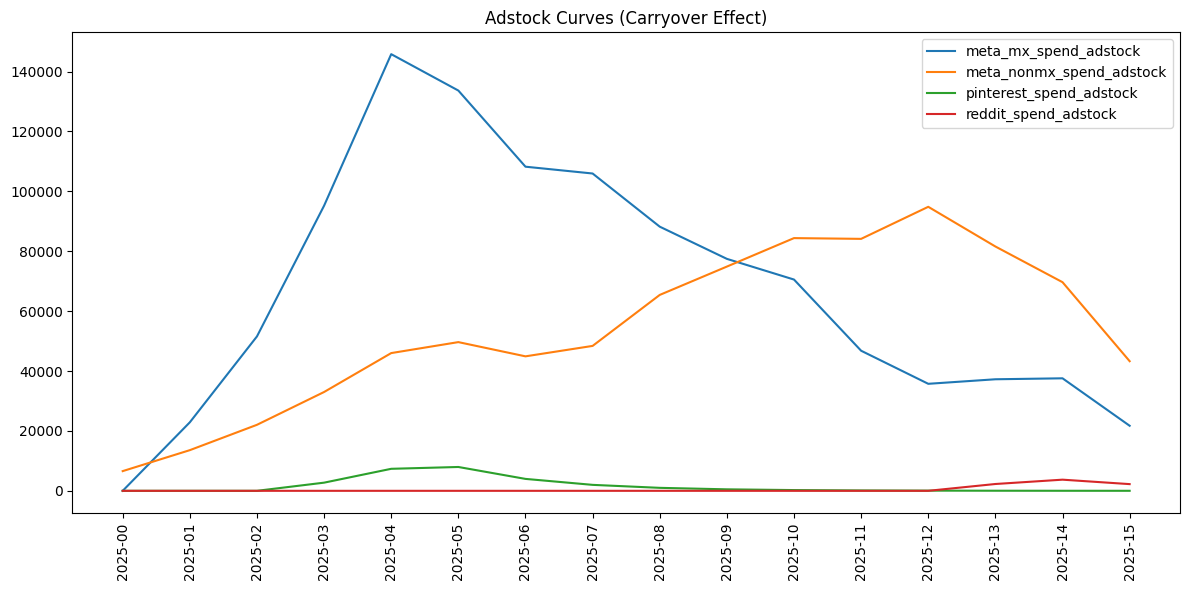

In [79]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
for col in ['meta_mx_spend_adstock', 'meta_nonmx_spend_adstock',
            'pinterest_spend_adstock', 'reddit_spend_adstock']:
    plt.plot(weekly_df['year_week'], weekly_df[col], label=col)

plt.xticks(rotation=90)
plt.title("Adstock Curves (Carryover Effect)")
plt.legend()
plt.tight_layout()
plt.show()


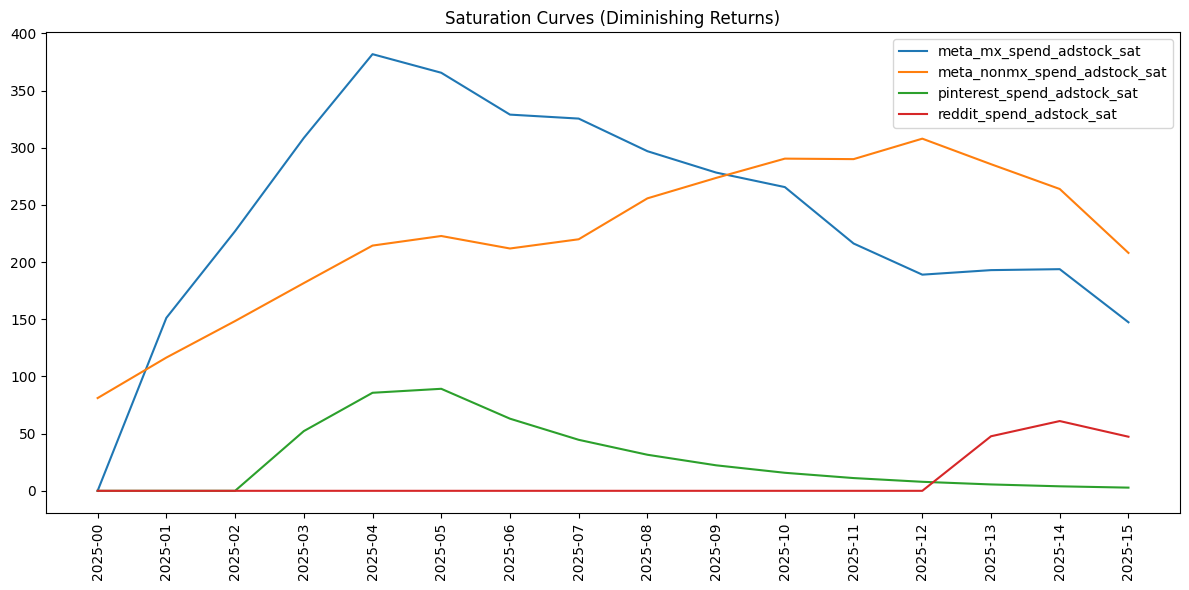

In [80]:
plt.figure(figsize=(12, 6))
for col in ['meta_mx_spend_adstock_sat', 'meta_nonmx_spend_adstock_sat',
            'pinterest_spend_adstock_sat', 'reddit_spend_adstock_sat']:
    plt.plot(weekly_df['year_week'], weekly_df[col], label=col)

plt.xticks(rotation=90)
plt.title("Saturation Curves (Diminishing Returns)")
plt.legend()
plt.tight_layout()
plt.show()


In [82]:
import statsmodels.api as sm

X = weekly_df[[
    'meta_mx_spend_adstock_sat',
    'meta_nonmx_spend_adstock_sat',
    'pinterest_spend_adstock_sat',
    'reddit_spend_adstock_sat'
]]

X = sm.add_constant(X)
y = weekly_df['revenue']

model = sm.OLS(y, X).fit()
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                revenue   R-squared:                       0.410
Model:                            OLS   Adj. R-squared:                  0.195
Method:                 Least Squares   F-statistic:                     1.910
Date:                Wed, 11 Feb 2026   Prob (F-statistic):              0.179
Time:                        01:43:08   Log-Likelihood:                -261.64
No. Observations:                  16   AIC:                             533.3
Df Residuals:                      11   BIC:                             537.1
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const           

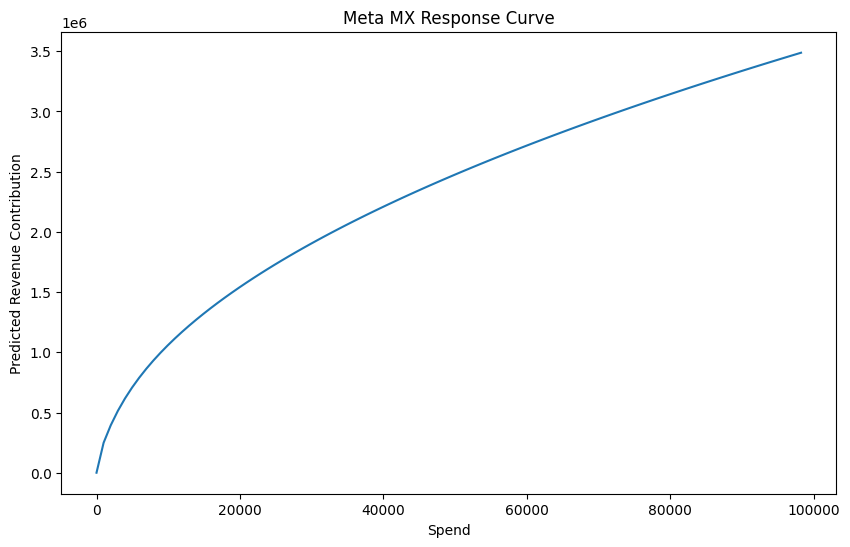

In [83]:
import numpy as np

def response_curve(spend, coef, alpha=0.5, rate=0.5):
    ad = adstock(spend, rate)
    sat = hill_saturation(ad, alpha)
    return coef * sat

plt.figure(figsize=(10, 6))

spend_range = np.linspace(0, weekly_df['meta_mx_spend'].max(), 100)
coef = model.params['meta_mx_spend_adstock_sat']

plt.plot(spend_range, response_curve(spend_range, coef))
plt.title("Meta MX Response Curve")
plt.xlabel("Spend")
plt.ylabel("Predicted Revenue Contribution")
plt.show()


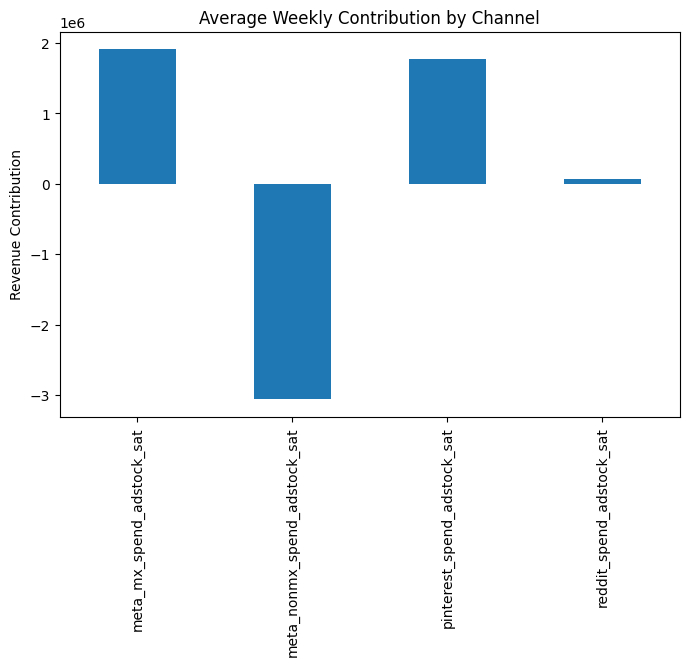

In [84]:
contrib = model.params[1:] * weekly_df[[
    'meta_mx_spend_adstock_sat',
    'meta_nonmx_spend_adstock_sat',
    'pinterest_spend_adstock_sat',
    'reddit_spend_adstock_sat'
]].mean()

contrib.plot(kind='bar', figsize=(8, 5), title="Average Weekly Contribution by Channel")
plt.ylabel("Revenue Contribution")
plt.show()


# Adding meta mx and meta-non mx in one for better clarity on the MMM model


In [85]:
weekly_df['meta_total_spend'] = (
    weekly_df['meta_mx_spend'] +
    weekly_df['meta_nonmx_spend']
)

weekly_df['other_spend'] = (
    weekly_df['pinterest_spend'] +
    weekly_df['reddit_spend']
)


In [86]:
weekly_df['meta_total_adstock'] = adstock(weekly_df['meta_total_spend'], rate=0.5)
weekly_df['other_adstock'] = adstock(weekly_df['other_spend'], rate=0.5)


In [87]:
weekly_df['meta_total_sat'] = hill_saturation(weekly_df['meta_total_adstock'], alpha=0.5)
weekly_df['other_sat'] = hill_saturation(weekly_df['other_adstock'], alpha=0.5)


In [88]:
weekly_df['trend'] = range(len(weekly_df))


In [89]:
import statsmodels.api as sm

X = weekly_df[['meta_total_sat', 'other_sat', 'trend']]
X = sm.add_constant(X)
y = weekly_df['revenue']

model = sm.OLS(y, X).fit()
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                revenue   R-squared:                       0.448
Model:                            OLS   Adj. R-squared:                  0.310
Method:                 Least Squares   F-statistic:                     3.249
Date:                Wed, 11 Feb 2026   Prob (F-statistic):             0.0600
Time:                        01:57:10   Log-Likelihood:                -261.10
No. Observations:                  16   AIC:                             530.2
Df Residuals:                      12   BIC:                             533.3
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const          -8.112e+04    3.4e+06     -0.

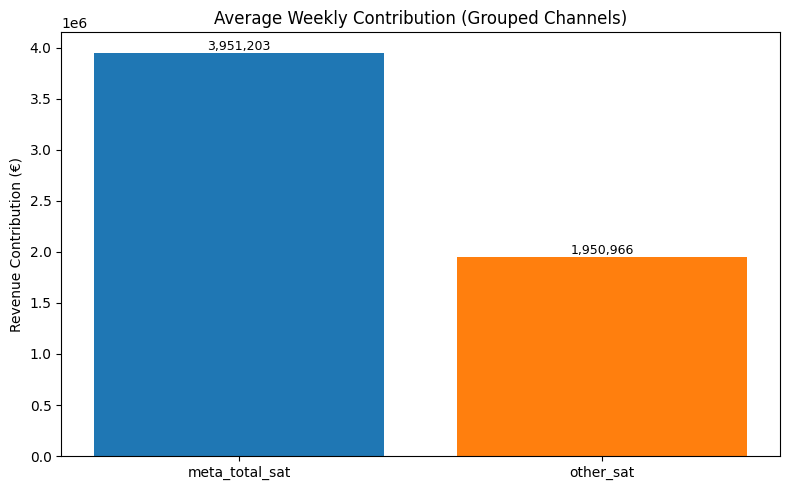

In [91]:
import matplotlib.pyplot as plt

# Channels you want to visualize
channels = ['meta_total_sat', 'other_sat']

# Compute contribution = coefficient × mean transformed value
contrib = {
    ch: model.params[ch] * weekly_df[ch].mean()
    for ch in channels
}

# Convert to lists for plotting
channel_names = list(contrib.keys())
contrib_values = list(contrib.values())

# Plot
plt.figure(figsize=(8, 5))
bars = plt.bar(channel_names, contrib_values, color=['#1f77b4', '#ff7f0e'])

plt.title("Average Weekly Contribution (Grouped Channels)")
plt.ylabel("Revenue Contribution (€)")
plt.xticks(rotation=0)

# Add value labels
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f"{height:,.0f}",
        ha='center',
        va='bottom',
        fontsize=9
    )

plt.tight_layout()
plt.show()


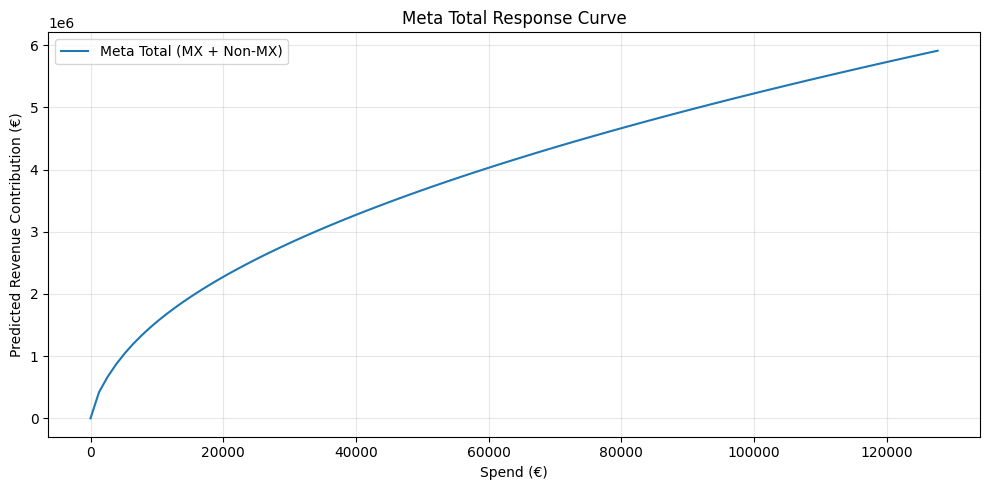

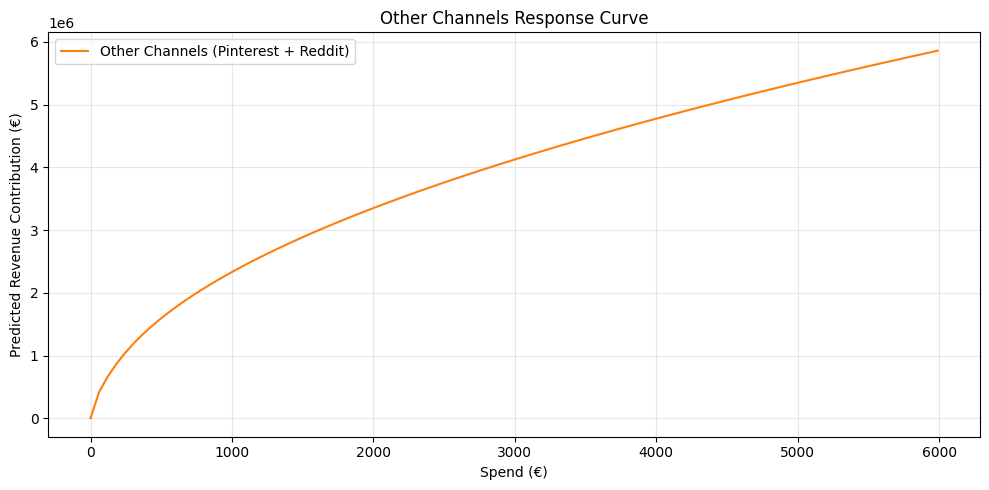

In [92]:
import numpy as np
import matplotlib.pyplot as plt

# --- Response curve function ---
def response_curve(spend, coef, rate=0.5, alpha=0.5):
    # Apply adstock
    ad = []
    carry = 0
    for x in spend:
        carry = x + rate * carry
        ad.append(carry)
    ad = np.array(ad)
    
    # Apply saturation
    sat = ad ** alpha
    
    # Predicted revenue contribution
    return coef * sat

# --- Spend ranges for plotting ---
max_meta = weekly_df['meta_total_spend'].max()
max_other = weekly_df['other_spend'].max()

spend_range_meta = np.linspace(0, max_meta, 100)
spend_range_other = np.linspace(0, max_other, 100)

# --- Coefficients from your model ---
coef_meta = model.params['meta_total_sat']
coef_other = model.params['other_sat']

# --- Plot Meta Total Response Curve ---
plt.figure(figsize=(10, 5))
plt.plot(spend_range_meta,
         response_curve(spend_range_meta, coef_meta),
         label='Meta Total (MX + Non‑MX)',
         color='#1f77b4')

plt.title("Meta Total Response Curve")
plt.xlabel("Spend (€)")
plt.ylabel("Predicted Revenue Contribution (€)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# --- Plot Other Channels Response Curve ---
plt.figure(figsize=(10, 5))
plt.plot(spend_range_other,
         response_curve(spend_range_other, coef_other),
         label='Other Channels (Pinterest + Reddit)',
         color='#ff7f0e')

plt.title("Other Channels Response Curve")
plt.xlabel("Spend (€)")
plt.ylabel("Predicted Revenue Contribution (€)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


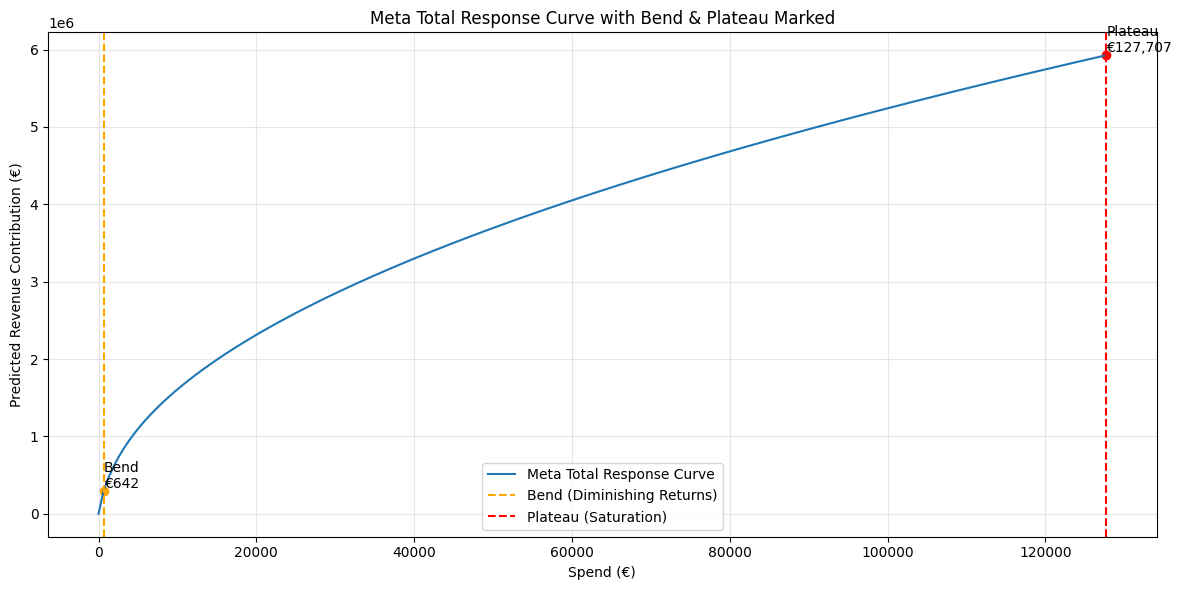

In [94]:
import numpy as np
import matplotlib.pyplot as plt

def response_curve(spend, coef, rate=0.5, alpha=0.5):
    ad = []
    carry = 0
    for x in spend:
        carry = x + rate * carry
        ad.append(carry)
    ad = np.array(ad)
    sat = ad ** alpha
    return coef * sat

# Spend range
max_spend = weekly_df['meta_total_spend'].max()
spend_range = np.linspace(0, max_spend, 200)

coef = model.params['meta_total_sat']
curve = response_curve(spend_range, coef)

# --- Bend point (max curvature) ---
second_derivative = np.gradient(np.gradient(curve))
bend_idx = np.argmin(second_derivative)
bend_spend = spend_range[bend_idx]
bend_value = curve[bend_idx]

# --- Plateau point (slope < threshold) ---
slope = np.gradient(curve)
threshold = slope.max() * 0.05  # 5% of max slope

plateau_candidates = np.where(slope < threshold)[0]

if len(plateau_candidates) > 0:
    plateau_idx = plateau_candidates[0]
else:
    plateau_idx = len(spend_range) - 1  # fallback: last point

plateau_spend = spend_range[plateau_idx]
plateau_value = curve[plateau_idx]

# --- Plot ---
plt.figure(figsize=(12, 6))
plt.plot(spend_range, curve, label='Meta Total Response Curve', color='#1f77b4')

# Bend point
plt.axvline(bend_spend, color='orange', linestyle='--', label='Bend (Diminishing Returns)')
plt.scatter(bend_spend, bend_value, color='orange')
plt.text(bend_spend, bend_value, f"Bend\n€{bend_spend:,.0f}", ha='left', va='bottom')

# Plateau point
plt.axvline(plateau_spend, color='red', linestyle='--', label='Plateau (Saturation)')
plt.scatter(plateau_spend, plateau_value, color='red')
plt.text(plateau_spend, plateau_value, f"Plateau\n€{plateau_spend:,.0f}", ha='left', va='bottom')

plt.title("Meta Total Response Curve with Bend & Plateau Marked")
plt.xlabel("Spend (€)")
plt.ylabel("Predicted Revenue Contribution (€)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


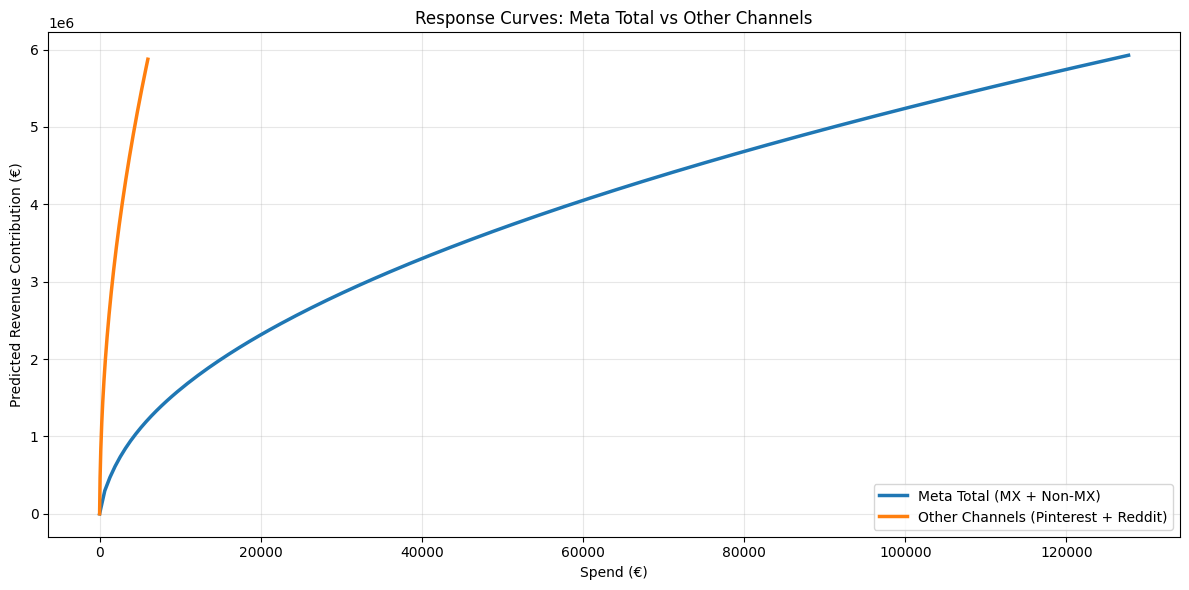

In [95]:
import numpy as np
import matplotlib.pyplot as plt

# --- Response curve function ---
def response_curve(spend, coef, rate=0.5, alpha=0.5):
    ad = []
    carry = 0
    for x in spend:
        carry = x + rate * carry
        ad.append(carry)
    ad = np.array(ad)
    sat = ad ** alpha
    return coef * sat

# --- Spend ranges for both channels ---
max_meta = weekly_df['meta_total_spend'].max()
max_other = weekly_df['other_spend'].max()

spend_meta = np.linspace(0, max_meta, 200)
spend_other = np.linspace(0, max_other, 200)

# --- Coefficients ---
coef_meta = model.params['meta_total_sat']
coef_other = model.params['other_sat']

# --- Curves ---
curve_meta = response_curve(spend_meta, coef_meta)
curve_other = response_curve(spend_other, coef_other)

# --- Plot ---
plt.figure(figsize=(12, 6))

plt.plot(spend_meta, curve_meta, label='Meta Total (MX + Non‑MX)', color='#1f77b4', linewidth=2.5)
plt.plot(spend_other, curve_other, label='Other Channels (Pinterest + Reddit)', color='#ff7f0e', linewidth=2.5)

plt.title("Response Curves: Meta Total vs Other Channels")
plt.xlabel("Spend (€)")
plt.ylabel("Predicted Revenue Contribution (€)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


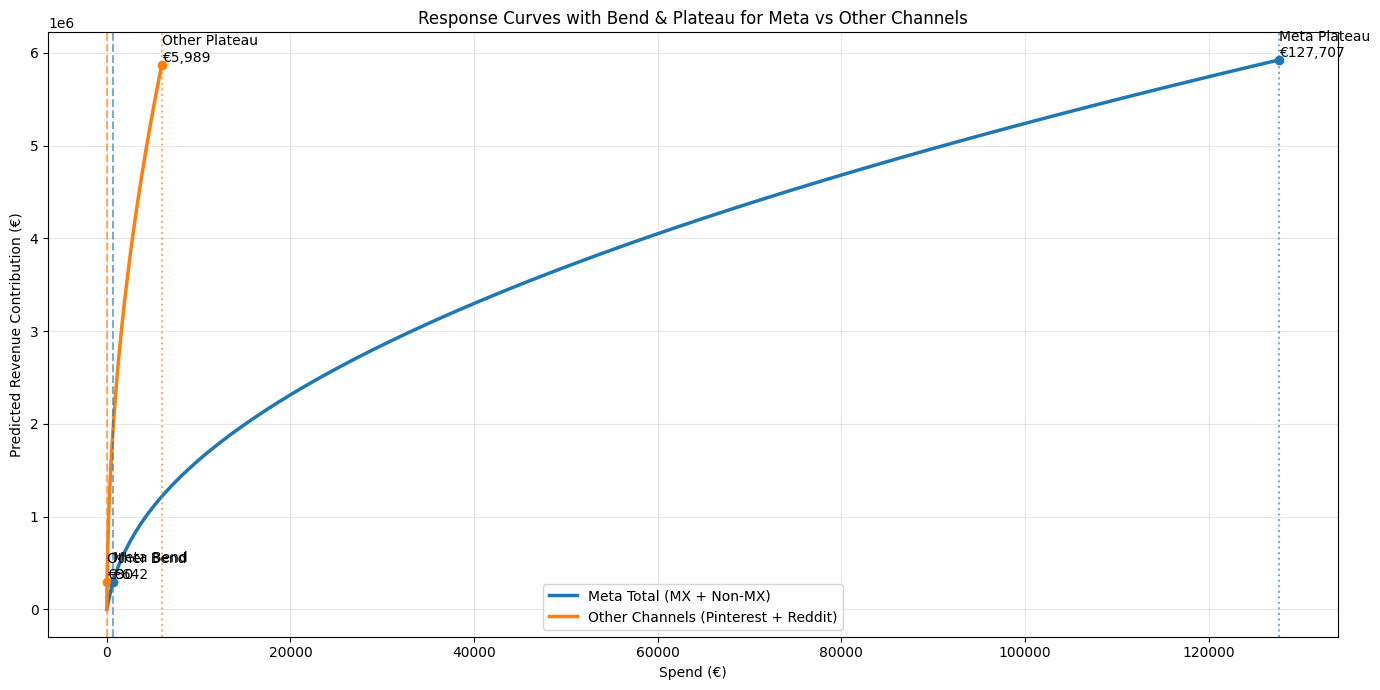

In [96]:
import numpy as np
import matplotlib.pyplot as plt

# --- Response curve function ---
def response_curve(spend, coef, rate=0.5, alpha=0.5):
    ad = []
    carry = 0
    for x in spend:
        carry = x + rate * carry
        ad.append(carry)
    ad = np.array(ad)
    sat = ad ** alpha
    return coef * sat

# --- Helper to compute bend + plateau ---
def compute_bend_plateau(spend_range, curve):
    # Bend = max curvature (most negative second derivative)
    second_derivative = np.gradient(np.gradient(curve))
    bend_idx = np.argmin(second_derivative)
    
    # Plateau = slope < 5% of max slope
    slope = np.gradient(curve)
    threshold = slope.max() * 0.05
    plateau_candidates = np.where(slope < threshold)[0]
    
    if len(plateau_candidates) > 0:
        plateau_idx = plateau_candidates[0]
    else:
        plateau_idx = len(spend_range) - 1  # fallback
    
    return bend_idx, plateau_idx

# --- Spend ranges ---
max_meta = weekly_df['meta_total_spend'].max()
max_other = weekly_df['other_spend'].max()

spend_meta = np.linspace(0, max_meta, 200)
spend_other = np.linspace(0, max_other, 200)

# --- Coefficients ---
coef_meta = model.params['meta_total_sat']
coef_other = model.params['other_sat']

# --- Curves ---
curve_meta = response_curve(spend_meta, coef_meta)
curve_other = response_curve(spend_other, coef_other)

# --- Compute bend + plateau ---
bend_meta, plateau_meta = compute_bend_plateau(spend_meta, curve_meta)
bend_other, plateau_other = compute_bend_plateau(spend_other, curve_other)

# --- Plot ---
plt.figure(figsize=(14, 7))

# Curves
plt.plot(spend_meta, curve_meta, label='Meta Total (MX + Non‑MX)', color='#1f77b4', linewidth=2.5)
plt.plot(spend_other, curve_other, label='Other Channels (Pinterest + Reddit)', color='#ff7f0e', linewidth=2.5)

# Meta markers
plt.axvline(spend_meta[bend_meta], color='#1f77b4', linestyle='--', alpha=0.6)
plt.scatter(spend_meta[bend_meta], curve_meta[bend_meta], color='#1f77b4')
plt.text(spend_meta[bend_meta], curve_meta[bend_meta],
         f"Meta Bend\n€{spend_meta[bend_meta]:,.0f}", ha='left', va='bottom')

plt.axvline(spend_meta[plateau_meta], color='#1f77b4', linestyle=':', alpha=0.6)
plt.scatter(spend_meta[plateau_meta], curve_meta[plateau_meta], color='#1f77b4')
plt.text(spend_meta[plateau_meta], curve_meta[plateau_meta],
         f"Meta Plateau\n€{spend_meta[plateau_meta]:,.0f}", ha='left', va='bottom')

# Other markers
plt.axvline(spend_other[bend_other], color='#ff7f0e', linestyle='--', alpha=0.6)
plt.scatter(spend_other[bend_other], curve_other[bend_other], color='#ff7f0e')
plt.text(spend_other[bend_other], curve_other[bend_other],
         f"Other Bend\n€{spend_other[bend_other]:,.0f}", ha='left', va='bottom')

plt.axvline(spend_other[plateau_other], color='#ff7f0e', linestyle=':', alpha=0.6)
plt.scatter(spend_other[plateau_other], curve_other[plateau_other], color='#ff7f0e')
plt.text(spend_other[plateau_other], curve_other[plateau_other],
         f"Other Plateau\n€{spend_other[plateau_other]:,.0f}", ha='left', va='bottom')

plt.title("Response Curves with Bend & Plateau for Meta vs Other Channels")
plt.xlabel("Spend (€)")
plt.ylabel("Predicted Revenue Contribution (€)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()
